In [10]:
import numpy as np 
import matplotlib.pyplot as plt
import wandb
import pandas as pd

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ericjm (ericjmichaud_). Use `wandb login --relogin` to force relogin


True

## Dense TopK

In [3]:
api = wandb.Api()
run = api.run("ericjmichaud_/switch_saes_scaling_laws_attempt_0/lxo4heat")

In [4]:
run.summary

{'AutoEncoderTopK-0/auxk_loss': 2.8813687436013424e-07, 'AutoEncoderTopK-0/cossim': 0.9319726824760436, 'AutoEncoderTopK-0/dead_features': 2, 'AutoEncoderTopK-0/effective_l0': 32, 'AutoEncoderTopK-0/frac_alive': 0.00048828125, 'AutoEncoderTopK-0/frac_recovered': 0.9782609939575196, 'AutoEncoderTopK-0/frac_variance_explained': 0.9760941863059998, 'AutoEncoderTopK-0/l0': 184.07421875, 'AutoEncoderTopK-0/l1_loss': 531.9281005859375, 'AutoEncoderTopK-0/l2_loss': 42.68992614746094, 'AutoEncoderTopK-0/l2_ratio': 0.9318945407867432, 'AutoEncoderTopK-0/loss': 1907.51416015625, 'AutoEncoderTopK-0/loss_original': 3.3303754329681396, 'AutoEncoderTopK-0/loss_reconstructed': 3.635465621948242, 'AutoEncoderTopK-0/loss_zero': 17.364578247070312, 'AutoEncoderTopK-0/mse_loss': 1920.7938232421875, 'AutoEncoderTopK-1/auxk_loss': 1.0362981583966755e-06, 'AutoEncoderTopK-1/cossim': 0.9423092603683472, 'AutoEncoderTopK-1/dead_features': 8, 'AutoEncoderTopK-1/effective_l0': 32, 'AutoEncoderTopK-1/frac_alive'

In [5]:
run_names = list(run.config)
dict_sizes = {run_name: run.config[run_name]['dict_size'] for run_name in run_names}

In [11]:
history = run.scan_history()
data = pd.DataFrame(history)

In [13]:
# use FLOPS on the x axis
def flops_dense(step, activation_dim, dict_size, batch_size):
    forward = dict_size * activation_dim * 2 * batch_size
    backward = dict_size * activation_dim * 2 * batch_size
    return step * (forward + backward)

Text(0.5, 1.0, 'Dense TopK SAE training curves')

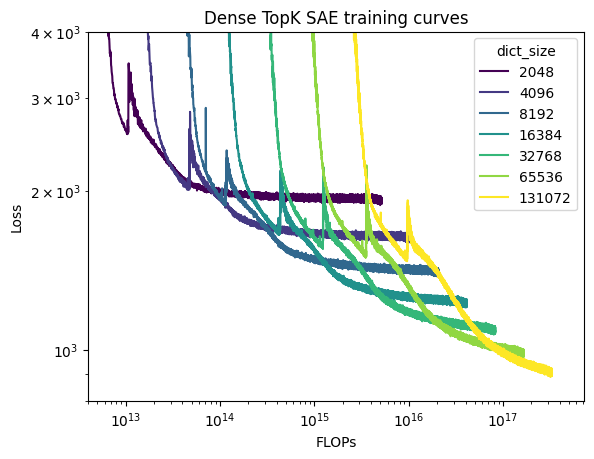

In [14]:
colors = plt.cm.viridis(np.linspace(0, 1, len(run_names)))
for i, run_name in enumerate(run_names):
    flops = flops_dense(
        np.array(data["_step"]),
        run.config[f"{run_name}"]["activation_dim"],
        run.config[f"{run_name}"]["dict_size"],
        # run.config[f"{run_name}"]["batch_size"]
        8192 # batch_size
    )
    losses = data[f"{run_name}/loss"].values
    plt.plot(flops, losses, label=dict_sizes[run_name], color=colors[i])

plt.xscale('log')
plt.yscale('log')

plt.ylim(8e2, 4e3)
plt.xlim(4e12, None)

plt.xlabel("FLOPs")
plt.ylabel('Loss')

plt.legend(title="dict_size")
plt.title("Dense TopK SAE training curves")


In [15]:
api = wandb.Api()
run8 = api.run("ericjmichaud_/switch_saes_scaling_laws_attempt_0/h6k7z6ra")

In [16]:
run_names8 = list(run8.config)
dict_sizes8 = {run_name: run8.config[run_name]['dict_size'] for run_name in run_names8}

In [17]:
history8 = run8.scan_history()
data8 = pd.DataFrame(history8)

In [18]:
# use FLOPS on the x axis
def flops_sparse(step, activation_dim, dict_size, batch_size, experts):
    return flops_dense(step, activation_dim, dict_size, batch_size) / experts
    # forward = dict_size * activation_dim * 2 * batch_size / experts
    # backward = dict_size * activation_dim * 2 * batch_size / experts
    # return np.array(step) * (forward + backward)

KeyError: 'AutoEncoderTopK-0/loss'

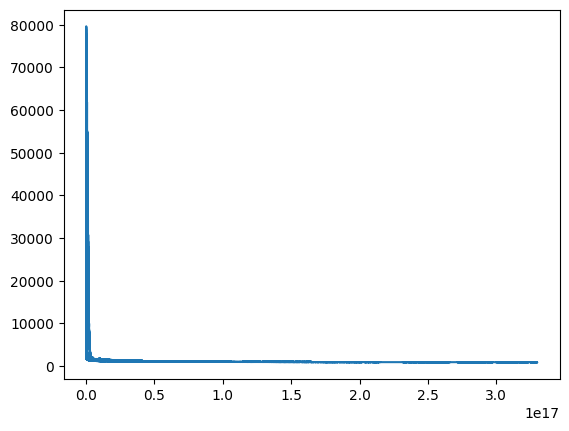

In [19]:
for i, run_name in enumerate(run_names):
    flops = flops_dense(
        np.array(data["_step"]),
        run.config[f"{run_name}"]["activation_dim"],
        run.config[f"{run_name}"]["dict_size"],
        # run.config[f"{run_name}"]["batch_size"]
        8192 # batch_size
    )
    losses = data[f"{run_name}/loss"].values
    plt.plot(flops, losses, label='Dense SAE' if i == 0 else None, color='C0')


for i, run_name in enumerate(run_names8):
    flops = flops_sparse(
        np.array(data8[f"{run_name}/loss"].index.tolist()),
        run8.config[f"{run_name}"]["activation_dim"],
        run8.config[f"{run_name}"]["dict_size"],
        # run8.config[f"{run_name}"]["batch_size"],
        8192, # batch_size
        8 # experts
    )
    # for some reason, the data run names are still AutoEncoderTopK, rather than SwitchAutoEncoder
    losses = data8[f"{run_name}/loss"].values
    plt.plot(flops, losses, label='Switch SAE: 8 experts' if i == 0 else None, color='C1')

plt.xscale('log')
plt.yscale('log')

plt.xlim(4e9, None)
plt.ylim(8e2, 4e3)

plt.xlabel("FLOPs")
plt.ylabel('Loss')

plt.legend(title="dict_size")
plt.title("Dense TopK SAE training curves")


In [74]:
np.array(data8[f"AutoEncoderTopK-{i}/loss"].index.tolist()), run8.config[f"{run_name}"]["activation_dim"], run8.config[f"{run_name}"]["dict_size"],

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177